In [1]:
import requests
import json
import re
import os
import pandas as pd 
import numpy as np
import random
import warnings

from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker, Classifier
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
import joblib
import pickle
from pattern_search import * 

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/Users/mvellera/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
# Set input file directory
ip_file_dir = "../Data/Target Data/"

# Get grocery product hierarchy information
group10 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group10_header.csv'),
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products.csv'))

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

In [3]:
group10.head(2)

,tcin,item_state,title,update_ts,brand_classification,brand_group,brand_id,brand,class_id,class_name,department_id,department_name,division_id,division_name,estore_item_status_c,estore_item_status,group_id,group_name,has_image,intended_selling_channels,is_published_flag,is_sellable,is_size_mix,is_standard_item,is_targetcom_ready,is_weight_required,item_kind,item_type_category_type,item_type_name,item_type,launch_date_time,manufacturer_brand,net_content_quantity_unit_of_measure,net_content_quantity_value,organic_c,package_depth,package_dimension_unit_of_measure,package_height,package_weight_unit_of_measure,package_weight,package_width,product_subtype_name,product_subtype,product_type_name,product_type,record_source_c,reference_color,reference_pattern_id,reference_size,relationship_kit_type,relationship_type_c,relationship_type,short_desc,size_chart,size_group_name,street_d,style_id,style_name,sub_group_id,sub_group_name,subclass_id,subclass_name,temperature_sensitivity_c,units_per_package,upc,variation_color,variation_other_label,variation_other,variation_size,variation_theme,price,rating,n_reviews,highlights,specifications,description,serving_info,nutrition_info,ingredients,allergens,images,image,title_modified,title_processed
0,12920260,READY_FOR_LAUNCH,Blue Diamond Almonds Wasabi & Soy Sauce - 6oz,2021-08-12 22:12:38,National-National,National,801,Blue Diamond Almonds,8,DC SALTY SNACKS,71,SNACKS,19,SNACKS/CANDY,A,Active,10,FOOD/BEVERAGE,True,Sold in Store,True,True,\N,\N,\N,\N,\N,\N,"Nuts, Seeds and Legumes",44601096,2010-08-19 07:00:00,\N,OUNCE,6,Not organic,3.54,INCH,2.72,POUND,0.46,3.38,SNACK,109516,GROCERY,109420,Corona,\N,\N,\N,\N,SA,Stand Alone,BLUE DIAMOND BLUE DIAMOND ALMONDS,\N,\N,\N,071-08-05-ABT66,B DIA ALMND S WSBI,24,SNACKS/BEV/CANDY,071-08-05,NUTS,\N,1,\N,\N,\N,\N,\N,\N,4.29,4.8,33.0,[Contains 6 - 6 ounce tins of Blue Diamond Bol...,"[Origin: Made in the USA or Imported, Package ...","When we first heard the idea, we were a little...","[Serving Size: 1 oz, Serving Per Container: 6]","[[Total Fat, 15g], [Saturated Fat, 1g], [Trans...","almonds, wasabi soy sauce seasoning (sugar, mo...",Allergens & Warnings:MAY CONTAIN OTHER TREE NUTS.,[https://target.scene7.com/is/image/Target/GUE...,https://target.scene7.com/is/image/Target/GUES...,blue diamond almonds wasabi soy sauce,wasabi soy sauce
1,12921061,READY_FOR_LAUNCH,Thomas' Everything Bagel Thins - 13oz/8ct,2021-08-29 07:08:41,National-National,National,7312,Thomas,1,BREAD,261,BREAD/BAKING,50,DRY GROCERY,A,Active,10,FOOD/BEVERAGE,True,Sold in Store,True,True,\N,\N,\N,\N,\N,\N,Bagels,74015137,2010-08-19 07:00:00,\N,OUNCE,13,Not organic,5.50,INCH,3.16,POUND,0.81,9.00,BREAD AND DESSERTS,120906,GROCERY,109420,Corona,\N,\N,\N,\N,SA,Stand Alone,THOMAS EVERYTHING THIN BAGELS,\N,\N,\N,261-01-02-AAD75,THOMAS BAGELS,25,DRY GROCERY,261-01-02,BREAKFAST,\N,1,\N,\N,\N,\N,\N,\N,3.89,4.6,32.0,[Contains 8 Thomas' Everything Bagel Thins per...,"[Origin: Made in the USA or Imported, TCIN: 12...",Everything you’re craving in a thinner bagel. ...,"[Serving Size: 46 g, Serving Per Container: 8]","[[Total Fat, 1g], [Saturated Fat, 0g], [Trans ...","enriched wheat flour [flour, malted barley flo...","Allergens & Warnings:CONTAINS WHEAT, SOY, SESA...",[https://target.scene7.com/is/image/Target/GUE...,https://target.scene7.com/is/image/Target/GUES...,thomas everything bagel thins ct,everything bagel thins


In [4]:
# bi_encoder_name = '/Users/mvellera/data/practicum/models/triplet-multi-qa-MiniLM-L6-cos-v1-style_name'
# lm = SentenceTransformer(bi_encoder_name)
lm = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [5]:
# Get list of preprocessed product titles
product_ids = group10['tcin'].values

In [6]:
group10['department_name'] = np.where(pd.isnull(group10['department_name']), '', group10['department_name'])
group10['class_name'] = np.where(pd.isnull(group10['class_name']), '', group10['class_name'])
group10['subclass_name'] = np.where(pd.isnull(group10['subclass_name']), '', group10['subclass_name'])
# group10['short_desc'] = np.where(pd.isnull(group10['short_desc']), '', group10['short_desc'])
group10['style_name'] = np.where(pd.isnull(group10['style_name']), '', group10['style_name'])
group10['item_type_name'] = np.where(pd.isnull(group10['item_type_name']), '', group10['item_type_name'])
# group10['highlights'] = np.where(pd.isnull(group10['highlights']), '', group10['highlights'])
# group10['description'] = np.where(pd.isnull(group10['description']), '', group10['description'])

product_sentences = list(group10['division_name'].str.cat(group10[['department_name', 'class_name', 
                                                                'item_type_name',                                                                  
                                                                'subclass_name', 
                                                                'style_name', 'title_processed'
                                                        ]], 
                                             sep= ' ').str.lower().values)

In [7]:
# # Compute embeddings
# pool = lm.start_multi_process_pool(target_devices=['cpu']*8)
# emb = lm.encode_multi_process(product_sentences, pool)
# # Store sentences & embeddings on disc
# with open('data/hier_embeddings.pkl', "wb") as fOut:
#     pickle.dump({'ids': product_ids,
#                  'sentences': product_sentences, 
#                  'embeddings': emb}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
#Load sentences & embeddings from disc
with open('data/hier_embeddings.pkl', "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']

In [9]:
tr = TransformerRanker(model=lm, product_ids=product_ids, max_rank=6)
tr.load_embeddings(stored_embeddings)
pm = Mapper(group10)
dp = DisplayProducts(ranker=tr, mapper=pm)

In [10]:
bi_encoder_name = "multi-qa-MiniLM-L6-cos-v1"
# bi_encoder_name = '/Users/mvellera/data/practicum/models/triplet-multi-qa-MiniLM-L6-cos-v1-division_name'
cross_encoder_name = "cross-encoder/ms-marco-MiniLM-L-4-v2"
embedding_loc = 'data/hier_embeddings.pkl'

clf_name_division_name = '/Users/mvellera/data/practicum/models/nli-classification-division_name'
clf_name_class_name = '/Users/mvellera/data/practicum/models/nli-classification-class_name'
clf_name_item_type_name = '/Users/mvellera/data/practicum/models/nli-classification-item_type_name'
clf_name_subclass_name = '/Users/mvellera/data/practicum/models/nli-classification-subclass_name'

k=3

In [11]:
base_clf_division_name = CrossEncoder(clf_name_division_name)
base_clf_class_name = CrossEncoder(clf_name_class_name)
base_clf_item_type_name = CrossEncoder(clf_name_item_type_name)
base_clf_subclass_name = CrossEncoder(clf_name_subclass_name)

clf_division_name = Classifier(base_clf_division_name, pm, 'division_name', threshold=0.99)
clf_class_name = Classifier(base_clf_class_name, pm, 'class_name', threshold=0.99)
clf_item_type_name = Classifier(base_clf_item_type_name, pm, 'item_type_name', threshold=0.99)
clf_subclass_name =  Classifier(base_clf_subclass_name, pm, 'subclass_name', threshold=0.99)

In [12]:
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

bi_encoder = SentenceTransformer(bi_encoder_name)

# Get list of preprocessed product titles
product_titles = group10['title'].str.lower().values

l1_ranker = TransformerRanker(model=bi_encoder, 
                              product_ids=group10['tcin'], 
                              max_rank=k,
                              clf=[clf_class_name,
                                   clf_item_type_name,
                                   clf_subclass_name])
with open(embedding_loc, "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_ids = stored_data['ids']
    stored_sentences = stored_data['sentences']
    stored_embeddings = stored_data['embeddings']
df = pd.DataFrame()
df['id'] = stored_data['ids']
df['sentence'] = stored_data['sentences']
l1_ranker.load_embeddings(stored_embeddings)

In [48]:
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2', max_length=512)
pm = Mapper(group10)
l2_ranker = CrossEncoderRanker(bi_model=l1_ranker, 
                                cross_model=cross_encoder_model, 
                                tcin_sentence_map=get_tcin_sentence_map(embedding_loc),
                                cross_rank=k,
                                bi_rank=30,
                                mapper=pm,
                                weights=True)

dp = DisplayProducts(ranker=l2_ranker, mapper=pm)
# dp = DisplayProducts(ranker=l1_ranker, mapper=pm)

spanish onion
[51586655, 14917313, 13474244, 14917361, 14916870, 77789463, 15414792, 79517436, 54562065, 78785310]


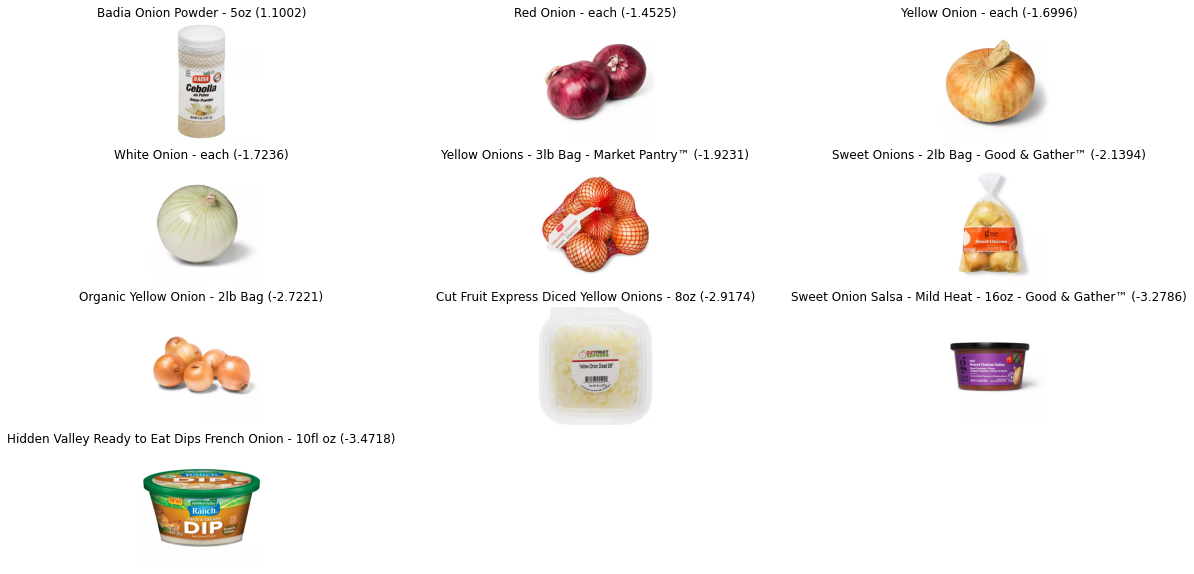

In [49]:
dp.display_products_ingredient('spanish onion', 10)

In [31]:
ingredient = 'red onion'
# tcin_list = clf.filter_by_hier(ingredient, tcin_list, 'class_name')

In [32]:
import torch
clf = clf_class_name
scores = clf.predict([ingredient])
scores = torch.nn.functional.softmax(torch.tensor(scores)).numpy()
n = 10
labels = [(clf.le.encoder[score_argmax], score_max)
    for score_argmax, score_max 
    in zip(scores.argsort()[-n:][::-1], sorted(scores, reverse=True)[0:n])]
labels

[('BFY SNACKS AND LOCAL CHIPS', 0.8254749),
 ('SPICES', 0.043413684),
 ('DC SALTY SNACKS', 0.0317941),
 ('CRACKERS', 0.026607601),
 ('FRITO LAY', 0.02108165),
 ('POTATOES/ONIONS', 0.014944726),
 ('POTATOES', 0.008068274),
 ('MEXICAN/BADIA/GOYA', 0.0024810343),
 ('SNACKS', 0.002289032),
 ('DRY GOODS', 0.0016441981)]

In [ ]:
# dp.display_products_ingredient_tcins(tcin_list[0:10])

,tcin,item_state,title,update_ts,brand_classification,brand_group,brand_id,brand,class_id,class_name,department_id,department_name,division_id,division_name,estore_item_status_c,estore_item_status,group_id,group_name,has_image,intended_selling_channels,is_published_flag,is_sellable,is_size_mix,is_standard_item,is_targetcom_ready,is_weight_required,item_kind,item_type_category_type,item_type_name,item_type,launch_date_time,manufacturer_brand,net_content_quantity_unit_of_measure,net_content_quantity_value,organic_c,package_depth,package_dimension_unit_of_measure,package_height,package_weight_unit_of_measure,package_weight,package_width,product_subtype_name,product_subtype,product_type_name,product_type,record_source_c,reference_color,reference_pattern_id,reference_size,relationship_kit_type,relationship_type_c,relationship_type,short_desc,size_chart,size_group_name,street_d,style_id,style_name,sub_group_id,sub_group_name,subclass_id,subclass_name,temperature_sensitivity_c,units_per_package,upc,variation_color,variation_other_label,variation_other,variation_size,variation_theme,price,rating,n_reviews,highlights,specifications,description,serving_info,nutrition_info,ingredients,allergens,images,image,title_modified,title_processed
5739,14917313,READY_FOR_LAUNCH,Red Onion - each,2021-07-22 17:20:42,National-National,National,17042,Bulk produce,17,POTATOES/ONIONS,211,VEGETABLES/PACKAGED VEG,62,PRODUCE/FLORAL,A,Active,10,FOOD/BEVERAGE,True,Sold in Store,True,True,\N,\N,\N,false,\N,\N,Vegetables,432323,2013-10-29 07:00:00,\N,EACH,1,Not organic,5.0,INCH,3.0,POUND,0.25,3.0,VEGETABLES AND FRUITS,120905,GROCERY,109420,Corona,\N,\N,\N,\N,SA,Stand Alone,ONION PF RED ONION EA,\N,\N,\N,211-17-09-AAG83,CONVENTIONAL ONION,33,PRODUCE/FLORAL,211-17-09,ONION,\N,1,\N,\N,\N,\N,\N,\N,0.99,3.5,60.0,"[Red onions are a classic kitchen staple, Gril...","[Origin: Made in the USA or Imported, Item Num...","Red Onions are extremely versatile, making the...",NaN,NaN,NaN,NaN,[https://target.scene7.com/is/image/Target/GUE...,https://target.scene7.com/is/image/Target/GUES...,red onion each,red onion each


In [42]:
ingredient = 'sugar'
noun = get_noun(ingredient)
hyponyms = get_hyponyms(ingredient)
hypernym = get_hypernym(ingredient)
synonyms = get_synonyms(ingredient)
multiple_nouns = get_noun_food(ingredient)
if len(multiple_nouns) and multiple_nouns != ingredient:
    query =  ingredient +  ' ' + multiple_nouns
# query =  " ".join(hyponyms) + ' ' + " ".join(synonyms) + ' ' + ingredient + ' ' + hypernym + ' ' + multiple_nouns
query

'brown sugar sugar loaf lump sugar cane sugar granulated sugar caramel corn sugar loaf sugar caramelized sugar sugarloaf beet sugar refined sugar clams lolly kale bread cabbage dough scratch lettuce sugar sugar sweetening sugar'

In [39]:
query

'garlic clove clove ail garlic garlic  garlic'

garlic clove clove ail garlic garlic  garlic
[13460105, 77586434, 13460775, 13556562, 13557065, 77616542, 14917452, 77616101, 13556561, 13557068]


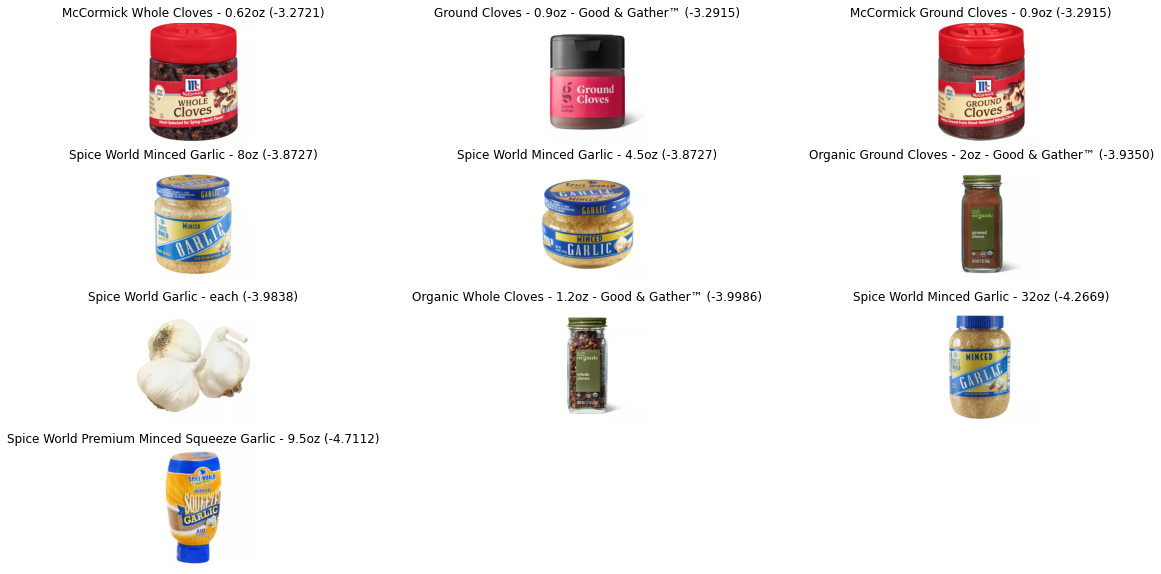

In [40]:
dp.display_products_ingredient(query, 10)

In [215]:
group10['division_name'].unique()

array(['SNACKS/CANDY', 'DRY GROCERY', 'DAIRY/FROZEN',
       'PROCESSED/FROZEN MEAT', 'NA BEVERAGES', 'PRODUCE/FLORAL', 'DELI',
       'ADULT BEVERAGES', 'FRESH MEAT', 'BAKERY', 'CAFE'], dtype=object)